# Solving Sudoku using Simulated Annealing

## Display Sudoku in a Graphical Mode for easy understanding of the initial state and solution state

### Visualization is done using the PyGame package

In [ ]:
!pip install pygame
!pip install pyfiglet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### PyGame Dependencies

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
from google.colab import output
import time 
import os, sys
import pyfiglet
import matplotlib.pyplot as plt

### Implementation of Sudoku Board drawing as a GUI

In [ ]:
# set SDL to use the dummy NULL video driver, 
# Fool system to think it has a video access
os.environ["SDL_VIDEODRIVER"] = "dummy"

import pygame

pygame.init()

# Set size of game and other constants
cell_size = 50
minor_grid_size = 1
major_grid_size = 3
buffer = 5
button_height = 50
button_width = 125
button_border = 2
width = cell_size * 9 + minor_grid_size * 6 + major_grid_size * 4 + buffer * 2
height = cell_size * 9 + minor_grid_size * 6 + \
         major_grid_size * 4 + button_height + buffer * 3 + button_border * 2
size = width, height
white = 255, 255, 255
black = 0, 0, 0
gray = 200, 200, 200
green = 0, 175, 0
red = 200, 0, 0
inactive_btn = 51, 255, 255
active_btn = 51, 153, 255

screen = pygame.display.set_mode(size)
pygame.display.set_caption('Sudoku')


'''
  A class built upon the pygame Rect class used to represent individual cells in the game.
  This class has a few extra attributes not contained within the base Rect class.
'''
class RectCell(pygame.Rect):

    def __init__(self, left, top, row, col):
        super().__init__(left, top, cell_size, cell_size)
        self.row = row
        self.col = col

'''Creates all 81 cells with RectCell class.'''
def create_cells():
    cells = [[] for _ in range(9)]

    # Set attributes for first RectCell
    row = 0
    col = 0
    left = buffer + major_grid_size
    top = buffer + major_grid_size

    while row < 9:
        while col < 9:
            cells[row].append(RectCell(left, top, row, col))

            # Update attributes for next RectCell
            left += cell_size + minor_grid_size
            if col != 0 and (col + 1) % 3 == 0:
                left = left + major_grid_size - minor_grid_size
            col += 1

        # Update attributes for next RectCell
        top += cell_size + minor_grid_size
        if row != 0 and (row + 1) % 3 == 0:
            top = top + major_grid_size - minor_grid_size
        left = buffer + major_grid_size
        col = 0
        row += 1

    return cells

'''Draws the major and minor grid lines for Sudoku.'''
def draw_grid():
    # Draw minor grid lines
    lines_drawn = 0
    pos = buffer + major_grid_size + cell_size
    while lines_drawn < 6:
        pygame.draw.line(screen, black, (pos, buffer),
                         (pos, width - buffer - 1), minor_grid_size)
        pygame.draw.line(screen, black, (buffer, pos),
                         (width - buffer - 1, pos), minor_grid_size)

        # Update number of lines drawn
        lines_drawn += 1

        # Update pos for next lines
        pos += cell_size + minor_grid_size
        if lines_drawn % 2 == 0:
            pos += cell_size + major_grid_size

    # Draw major grid lines
    for pos in range(buffer + major_grid_size // 2, width, cell_size * 3 + minor_grid_size * 2 + major_grid_size):
        pygame.draw.line(screen, black, (pos, buffer),
                         (pos, width - buffer - 1), major_grid_size)
        pygame.draw.line(screen, black, (buffer, pos),
                         (width - buffer - 1, pos), major_grid_size)


'''Fills in all the numbers for the game.'''
def fill_cells(all_cells, sudoku_board):
    font = pygame.font.Font(None, 36)

    # Fill in all cells with correct value
    for row in range(9):
        for col in range(9):
            if sudoku_board[row][col] is None:
                continue

            # Fill in given values
            font.bold = True
            text = font.render(f'{sudoku_board[row][col]}', 1, black)

            # Center text in cell
            xpos, ypos = all_cells[row][col].center
            textbox = text.get_rect(center=(xpos, ypos))
            screen.blit(text, textbox)


# Draws all elements making up the board.
def draw_board(all_cells, game):
    # Draw grid and cells
    draw_grid()

    # Fill in cell values
    fill_cells(all_cells, game)

'''The utility function called by the main method'''
def create_board_diagram(board):
    cells = create_cells()
    screen.fill(white)
    # Draw board
    draw_board(cells, board)
    # Update screen
    pygame.display.flip()
    #convert image so it can be displayed in OpenCV
    view = pygame.surfarray.array3d(screen)

    #  convert from (width, height, channel) to (height, width, channel)
    view = view.transpose([1, 0, 2])

    #  convert from rgb to bgr
    img_bgr = cv2.cvtColor(view, cv2.COLOR_RGB2BGR)

    return img_bgr


pygame 2.1.2 (SDL 2.0.16, Python 3.8.15)
Hello from the pygame community. https://www.pygame.org/contribute.html


#Sudoku puzzles consisting of 4 levels of difficulties were compiled into a json file and will be used to ascertain the performance of our group's algorithms across a uniform set of puzzles.

In [ ]:
import json
import copy
import numpy as np
from random import sample, randint
from copy import deepcopy


In [ ]:
sample_sudoku = {
    "easy": [
        [0,2,3,7,0,9,6,8,0],
        [0,7,0,0,6,0,4,0,3],
        [6,0,0,3,0,4,0,0,0],
        [8,0,7,0,0,0,0,0,6],
        [3,4,2,0,9,0,8,0,0],
        [9,5,0,0,0,7,3,0,0],
        [7,0,5,0,0,2,1,3,8],
        [2,6,0,0,3,0,0,0,7],
        [1,0,0,8,7,0,0,0,9]
    ],
    "medium": [
        [4,3,0,0,0,0,0,2,0],
        [6,0,8,9,0,0,0,0,0],
        [7,0,5,0,6,0,0,0,0],
        [8,7,0,0,0,2,0,0,5],
        [9,0,0,0,4,5,2,7,8],
        [0,4,2,8,0,0,9,6,3],
        [0,5,0,0,3,0,6,0,0],
        [0,0,0,0,2,0,0,0,0],
        [0,0,0,4,0,8,7,0,0]
    ],
    "hard": [
        [1,0,0,0,6,0,0,0,3],
        [0,0,0,0,1,0,0,0,0],
        [0,8,0,0,0,5,1,9,7],
        [0,7,5,0,0,1,0,3,9],
        [0,0,0,0,0,0,0,5,6],
        [8,4,0,0,0,0,0,0,2],
        [5,0,0,0,0,0,0,2,0],
        [4,0,8,0,0,2,6,7,0],
        [7,0,0,4,0,0,0,0,5]
    ],
    "evil": [
        [0,0,3,6,2,0,0,0,0],
        [0,0,0,0,0,0,0,0,0],
        [5,6,0,8,0,0,0,0,0],
        [0,0,6,4,8,0,3,7,0],
        [7,0,0,0,0,0,0,0,0],
        [0,8,9,1,0,0,6,4,0],
        [0,4,0,0,0,0,0,1,0],
        [0,0,0,0,1,0,0,0,0],
        [3,0,0,0,0,8,0,0,0]
    ]
}

TEMP = 0.5  # Default temperatures to use for the sudoku program

# Creating the Sudoku board

In [ ]:
# Makes a sudoku board randomly
class SudokuBoard:

    board = []

    def __init__(self, n=9):
        grid = self.make_sudoku(n, False)
        self.board = self.make_puzzle(grid, 50, False)

    '''
        Make sudoku of dimension n^2
        Input:
         n       : Dimension
         verbose : (Optional) Boolean, prints sudoku. Default value is False.
        Output:
         sudoku  : n^2 x n^2 grid of values
    '''
    def make_sudoku(self, n, verbose=False):
        side = n * n

        block = sample(range(0, n), n)
        block_itr = sample(range(0, n), n)

        nums = sample(range(1, side + 1), side)
        sudoku = []
        for r in block:
            for c in block_itr:
                start = r + n * c
                grid_row = []
                for k in range(side):
                    grid_row.append(nums[(start + k) % side])

                sudoku.append(grid_row)

        if verbose:
            self.print_sudoku(sudoku)

        return sudoku

    '''
    Randomly remove elements from a grid to make a sudoku puzzle
    Input:
     grid    : A grid (NxN dimension) of values
     n       : Number of elements to remove.
               This determines the difficulty of the puzzle.
     verbose : (Optional) Boolean that determines whether to print results.
               Default values is False.
    Output:
     puzzle  : a sudoku puzzle with zeros indicating the empty cells
    '''
    def make_puzzle(self, grid, n, verbose=False):  # n is # of elements to be removed
        temp_grid = deepcopy(grid)
        side = len(grid)
        if n >= side * side:
            raise ValueError(f"Cannot remove {n} elements from grid with {side * side} elements!")

        indices = np.random.choice(range(side * side), n, replace=False)

        for i in range(n):
            rows = indices[i] // side
            cols = indices[i] % side
            temp_grid[rows][cols] = 0

        if verbose:
            self.print_sudoku(temp_grid)

        return temp_grid


    '''
    Check if a filled grid is valid, i.e. follows all sudoku rules
    Input:
     puzzle : The grid to be checked
    Output:
     Returns boolean status of the puzzle
    '''
    def check_valid_sudoku(self, puzzle):

        side = len(puzzle)
        dim = int(np.sqrt(side))

        sqr = 0
        sqc = 0
        for r in range(side):
            row = np.array(puzzle[r])
            column = np.array(puzzle)[:, [r]].transpose()[0]

            ri = self.get_block_indices(sqr, dim)
            ci = self.get_block_indices(sqc, dim)
            square = np.array(puzzle)[ri, :][:, ci].reshape(side)

            sqr = sqr + dim

            if sqr == side:
                sqr = 0
                sqc = sqc + dim

            for val in range(1, side + 1):
                if len(np.where(row == val)[0]) > 1 or len(np.where(column == val)[0]) > 1 or len(
                        np.where(square == val)[0]) > 1:
                    return False

        return True

    def get_block_indices(self, start, dim):
        return list(range(start, start + dim))

    '''
      Prints a grid
      Input:
      puzzle: The grid to be printed
      Output:
      Returns nothing, but prints the puzzle as an image
    '''
    def print_sudoku(self, puzzle):
        img_bgr = create_board_diagram(puzzle)
        #Display image
        cv2_imshow(img_bgr)

        return

# Solving Sudoku using Simulated Annealing

Method

* It uniquely fills every nxn block in an n^2xn^2 puzzle randomly.
* It counts the number of unique elements in every row and column, assigning a score of -1 to each unique element.
* It picks a random nxn square in the puzzle and swaps two entries in it to calculate a "neighboring state".
* Calculates the score for the neighbor state 
* If the score is less than the previous score (i.e. delta < 0), then accept the new state
* Else, accepts/rejects with a certain probability 
* Cools the temperature by some cooling rate
* Repeat from step 2 till minimum score is reached.

---

The idea is that over time, as the temperature cools, it becomes less likely to accept a worse state of the puzzle so that given enough iterations, the annealer will solve the puzzle. 

Sometimes the simulation can get stuck. 

In this case, a reheating condition is included, so that the temperature is increased and it will accept a less likely state and travel a different random path to get to the solution.

```
     Input:
      puzzle_input    : The puzzle to solve as n^2 x n^2 list with zeros marking the empty cells
      max_iterations   : (Optional) The number fo iterations to try before giving up (int)
      t               : (Optional) The temperature (double)
      cooling_rate     : (Optional) The rate at which to reduce the temperature. The temperature is reduced geometrically. (double)
      verbose         : (Optional) Whether to print info (Boolean)

     Output:
      Returns solved puzzle
```

In [ ]:
'''
    Input:
      puzzle_input     : The puzzle to solve as n^2 x n^2 list with zeros marking the empty cells
      max_iterations   : (Optional) The number fo iterations to try before giving up (int)
      t                : (Optional) The temperature (double)
      cooling_rate     : (Optional) The rate at which to reduce the temperature. The temperature is reduced geometrically. (double)
      verbose          : (Optional) Whether to print info (Boolean), default is False

    Output:
      Returns solved puzzle
'''
def solve_sudoku(puzzle_input, max_iterations=5000000, t=TEMP, cooling_rate=1.0 - 1e-5, verbose=False):
    reheat_rate = t / 0.3

    puzzle = copy.deepcopy(puzzle_input)
    side = len(puzzle)
    sq_size = int(np.sqrt(side))

    empty_cells = reset_empty_cells(puzzle)

    # map containing step number and heuristic value
    iteration_heuristic_map = {}

    # Start annealing
    heuristic_score = unique_element_heuristic_count(puzzle)
    target_score = -2 * side * side
    best_score = heuristic_score
    stuck_count = 0
    total_iterations = 0

    for i in range(max_iterations):
        total_iterations = i
        if i % 10000 == 0 and verbose:
            print("Iteration " + str(i) + ", current score:" + str(heuristic_score) + "  Best score: " + str(best_score))

        # Adjust temperature
        if heuristic_score == target_score or t == 0:
            break

        # If stuck then reheat the annealer
        if stuck_count > 5000 or t < 1e-4:
            print("Annealer is stuck at T={} and stuck_count={}, so re-initializing... given iteration count={}".format(t, stuck_count, iterations))
            t = t * reheat_rate
            puzzle = copy.deepcopy(puzzle_input)
            empty_cells = reset_empty_cells(puzzle)
            stuck_count = 0

        neighbor_puzzle = find_swappable_neighbors_in_block(puzzle, empty_cells)  # Find neighbouring state
        s2 = unique_element_heuristic_count(neighbor_puzzle)  # Energy of neighbouring state
        delta_s = float(s2 - heuristic_score)  # Energy difference
        if delta_s < 0:
            puzzle = copy.deepcopy(neighbor_puzzle)
            heuristic_score = s2
            if heuristic_score < best_score:
                best_score = heuristic_score
            stuck_count = 0
        else:
            probability = np.exp(-delta_s / t)  # Acceptance probability
            random_probability = np.random.uniform(low=0, high=1, size=1)
            if probability > random_probability:  # Acceptance condition, ref: accept-reject sampling
                puzzle = copy.deepcopy(neighbor_puzzle)
                heuristic_score = s2
                if heuristic_score < best_score:
                    best_score = heuristic_score
                stuck_count = 0

        stuck_count += 1
        iteration_heuristic_map[i] = heuristic_score
        t = cooling_rate * t

    return total_iterations, heuristic_score, puzzle, iteration_heuristic_map


"""
    Used mostly during the initial run and subsequent reheating procedure of simulated annealing.
    Input:
     puzzle : ndarray (NxN) containing the puzzle
    Output:
     Initializes the puzzle in place.
     Returns a list containing the empty cells in the puzzle.
     The convention in empty_cells is as below
     For the first 2 square blocks of a puzzle shown below:
     5|0|7 || 1|0|0
     6|1|2 || 0|3|4
     0|0|0 || 9|5|8

     empty_cells = [[(0,1),(2,0),(2,1),(2,2)],
                    [(0,4),(0,5),(1,3)]]
    i.e, each row corresponds to empty cells in a square block
"""
def reset_empty_cells(puzzle):
    side = len(puzzle)
    sq_size = int(np.sqrt(side))

    i = 0
    j = 0
    empty_cells = []
    square = []
    square_count = 0
    while i < side and j < side:

        square.append(puzzle[i][j:j + sq_size])

        if (i + 1) % sq_size == 0 and (j + sq_size) % sq_size == 0:

            fixed_cells = []
            empty = []

            values = list(range(1, side + 1))
            # Find empty cells and fixed cells in the block
            for row in range(sq_size):
                empty.append(np.where(np.array(square)[row] == 0)[0].tolist())
                fixed_cells.append(np.where(np.array(square)[row] != 0)[0].tolist())

                # Find fixed values in the block
                for f in fixed_cells[row]:
                    values.remove(square[row][f])

            # Map empty cell to puzzle indices
            index_map = map_empty_cells(empty, sq_size, square_count)
            empty_cells.append(index_map)

            # Fill empty cells in the block uniquely
            for cell in index_map:
                random_val = sample(values, 1)[0]

                puzzle[cell[0]][cell[1]] = random_val

                values.remove(random_val)

            square_count += 1
            j += sq_size
            i -= sq_size
            square = []
            if j % side == 0:
                i = i + sq_size
                j = 0

        i += 1

    return empty_cells


def map_empty_cells(empty_cells, dim, square_count):
    empty_puzzle_cells = []

    for row in range(dim):
        for col in empty_cells[row]:
            r = row + dim * (square_count // dim)
            c = col + dim * (square_count % dim)
            empty_puzzle_cells.append((r, c))
    return empty_puzzle_cells


"""
    Calculate the score for a puzzle. Puzzle is scored by number of unique elements in every row and column.
"""
def unique_element_heuristic_count(puzzle):
    side = len(puzzle)
    heuristic_score = 0

    # Count in the columns
    puzzle_transpose = list(zip(*puzzle))
    for i in range(side):
        # Score by unique elements
        heuristic_score -= len(list(set(puzzle[i])))
        heuristic_score -= len(list(set(puzzle_transpose[i])))

    return heuristic_score


"""
    Find a neighboring state of the puzzle by swapping two of its entries in a random block.
    Input:
     puzzle      : grid of values
     empty_cells : list of empty cells in the format returned by Initialize()
    Output:
     new_puzzle  : Next nearest neighbor by swapping 2 entries
"""
def find_swappable_neighbors_in_block(puzzle, empty_cells):
    side = len(puzzle)
    sq_size = int(np.sqrt(side))
    new_puzzle = copy.deepcopy(puzzle)

    empty_block_size = 0
    random_block = -1
    while empty_block_size < 2:
        # Pick a random block
        random_block = randint(0, side - 1)
        empty_block_size = len(empty_cells[random_block])

    # Randomly find 2 cells in the block to swap
    a, b = sample(range(len(empty_cells[random_block])), 2)
    cell1, cell2 = empty_cells[random_block][a], empty_cells[random_block][b]

    # Swap entries
    temp = new_puzzle[cell1[0]][cell1[1]]
    new_puzzle[cell1[0]][cell1[1]] = new_puzzle[cell2[0]][cell2[1]]
    new_puzzle[cell2[0]][cell2[1]] = temp

    return new_puzzle

# Running the Sudoku Solver using the 4 sample inputs

                      
  ___  __ _ ___ _   _ 
 / _ \/ _` / __| | | |
|  __/ (_| \__ \ |_| |
 \___|\__,_|___/\__, |
                |___/ 

Initial state of the board


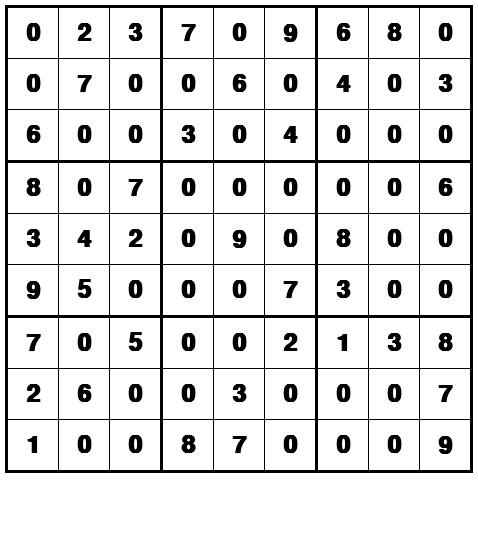

Solved!!
Total number of iterations done:  4868  to get score: -162

Solution:



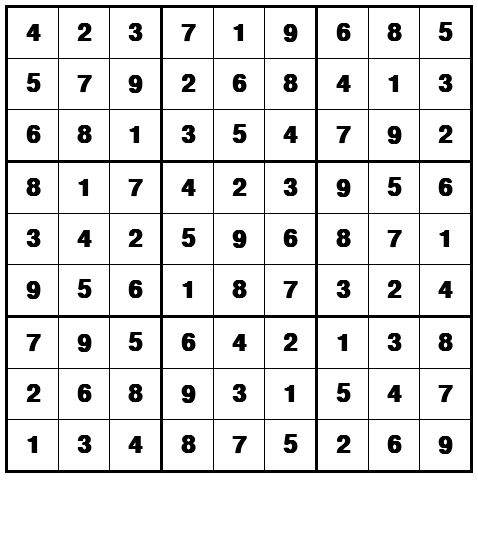

Simulated Annealing graph


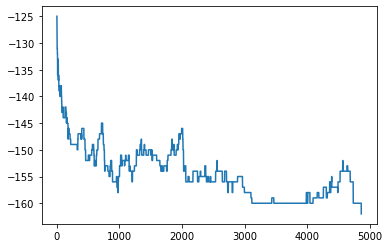

                    _ _                 
 _ __ ___   ___  __| (_)_   _ _ __ ___  
| '_ ` _ \ / _ \/ _` | | | | | '_ ` _ \ 
| | | | | |  __/ (_| | | |_| | | | | | |
|_| |_| |_|\___|\__,_|_|\__,_|_| |_| |_|
                                        

Initial state of the board


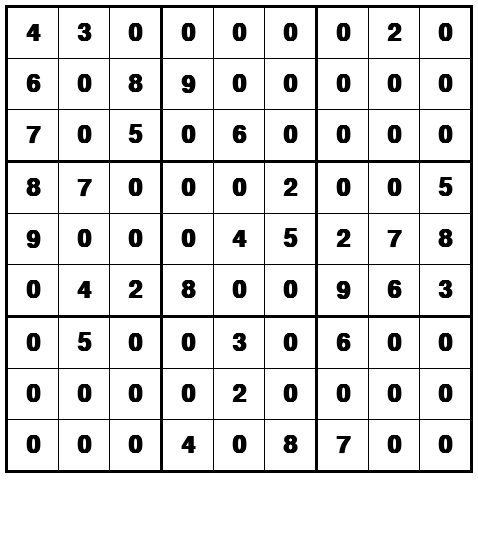

Solved!!
Total number of iterations done:  1980  to get score: -162

Solution:



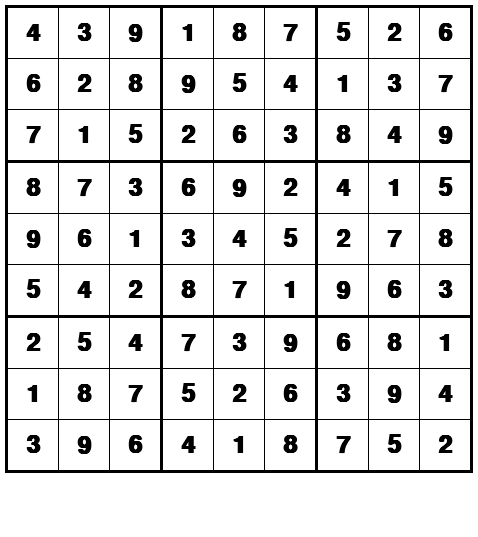

Simulated Annealing graph


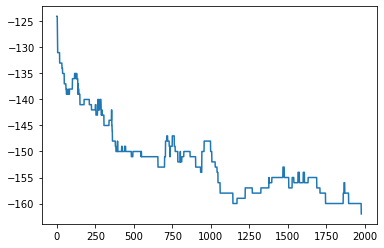

 _                   _ 
| |__   __ _ _ __ __| |
| '_ \ / _` | '__/ _` |
| | | | (_| | | | (_| |
|_| |_|\__,_|_|  \__,_|
                       

Initial state of the board


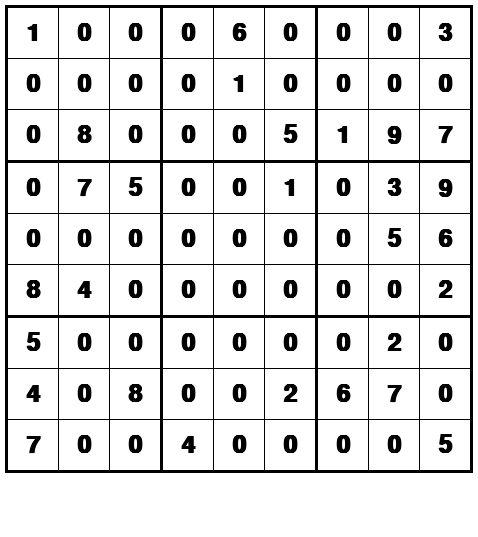

Solved!!
Total number of iterations done:  33736  to get score: -162

Solution:



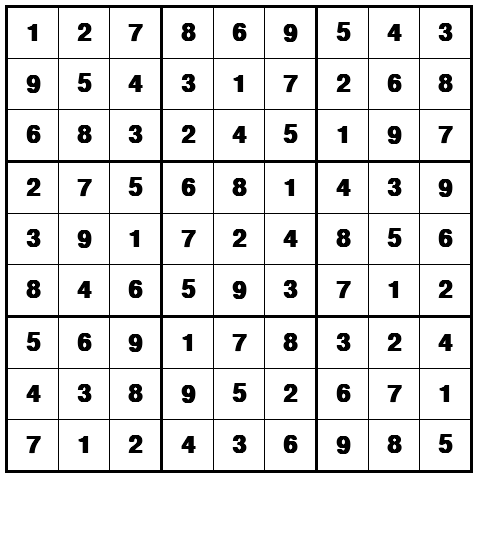

Simulated Annealing graph


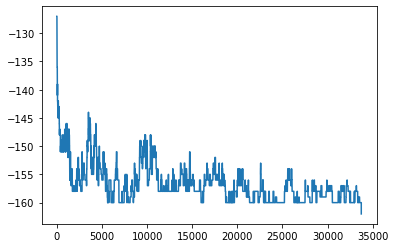

            _ _ 
  _____   _(_) |
 / _ \ \ / / | |
|  __/\ V /| | |
 \___| \_/ |_|_|
                

Initial state of the board


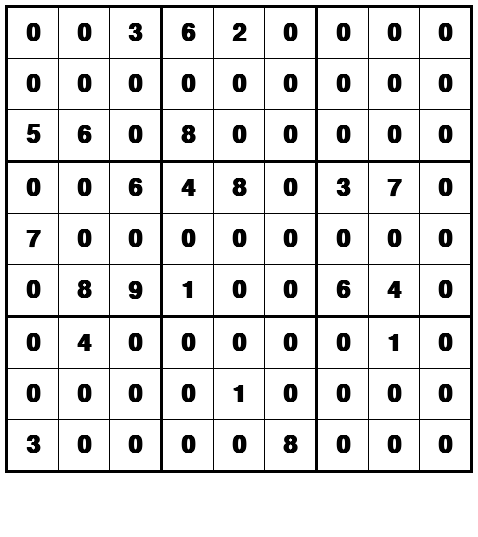

Solved!!
Total number of iterations done:  22084  to get score: -162

Solution:



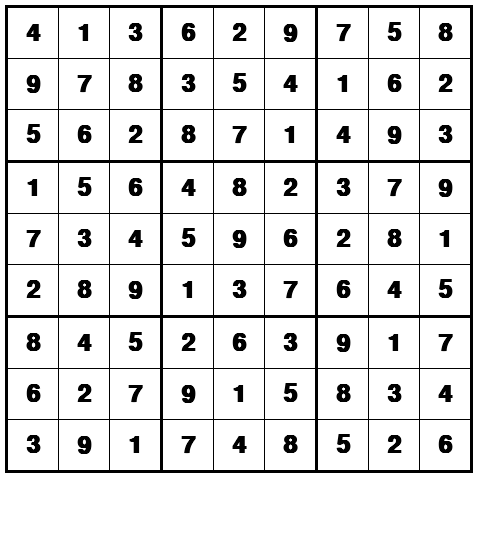

Simulated Annealing graph


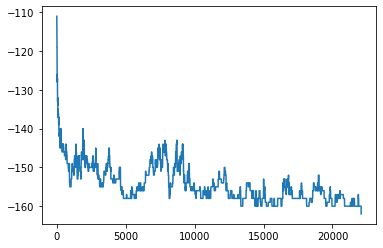

 ____                 _                   ____            _       _          
|  _ \ __ _ _ __   __| | ___  _ __ ___   / ___| _   _  __| | ___ | | ___   _ 
| |_) / _` | '_ \ / _` |/ _ \| '_ ` _ \  \___ \| | | |/ _` |/ _ \| |/ / | | |
|  _ < (_| | | | | (_| | (_) | | | | | |  ___) | |_| | (_| | (_) |   <| |_| |
|_| \_\__,_|_| |_|\__,_|\___/|_| |_| |_| |____/ \__,_|\__,_|\___/|_|\_\\__,_|
                                                                             



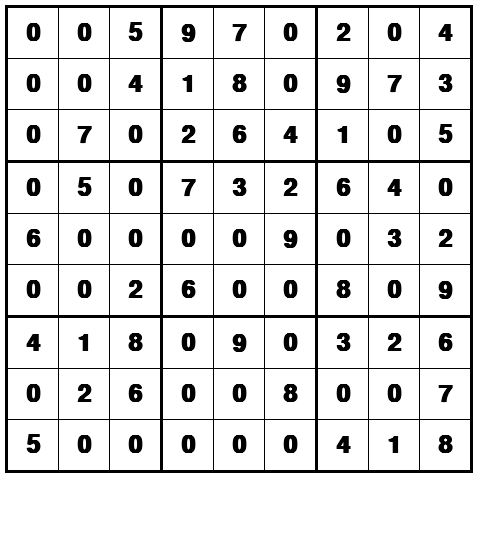

Solved!!
Total number of iterations done:  400  to get score: -162

Solution:



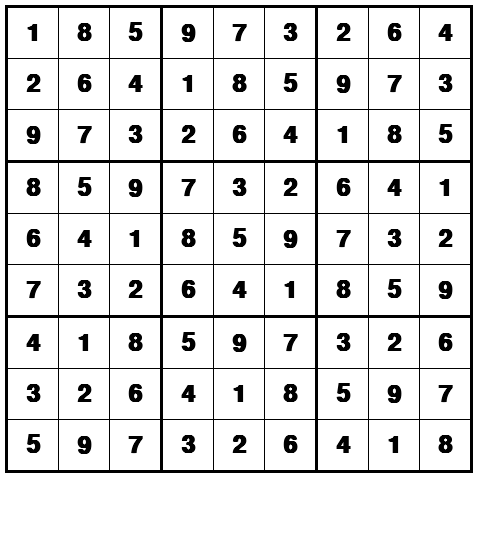

Simulated Annealing graph


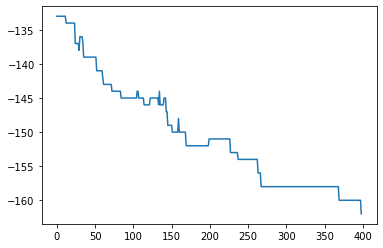

In [ ]:
if __name__ == "__main__":

    for level, puzzle in sample_sudoku.items():
      ascii_banner = pyfiglet.figlet_format(level)
      print(ascii_banner)
      sudoku_new = SudokuBoard(3)
      print("Initial state of the board")
      sudoku_new.print_sudoku(puzzle)
      sudoku_new.board = puzzle
      iterations, score, solution_board, iteration_heuristic_map = solve_sudoku(sudoku_new.board)
      assert sudoku_new.check_valid_sudoku(solution_board) is True
      print("Solved!!")
      print("Total number of iterations done: ", iterations + 1, " to get score:", score)
      # Print solution
      print("\nSolution:\n")
      sudoku_new.print_sudoku(solution_board)

      print("Simulated Annealing graph")
      steps = list(iteration_heuristic_map.keys())           
      heuristic_values = list(iteration_heuristic_map.values())        
      plt.plot(steps, heuristic_values)
      plt.show()
      
    ascii_banner = pyfiglet.figlet_format("Random Sudoku")
    print(ascii_banner)
    sudoku_random = SudokuBoard(3)
    grid = sudoku_random.make_sudoku(3)
    number_of_empty_cells = 35
    puzzle = sudoku_random.make_puzzle(grid, number_of_empty_cells)
    sudoku_random.print_sudoku(puzzle)
    sudoku_random.board = puzzle
    iterations, score, solution_board, iteration_heuristic_map = solve_sudoku(sudoku_random.board)
    assert sudoku_random.check_valid_sudoku(solution_board) is True
    print("Solved!!")
    print("Total number of iterations done: ", iterations + 1, " to get score:", score)
    # Print solution
    print("\nSolution:\n")
    sudoku_random.print_sudoku(solution_board)

    print("Simulated Annealing graph")
    steps = list(iteration_heuristic_map.keys())           
    heuristic_values = list(iteration_heuristic_map.values())        
    plt.plot(steps, heuristic_values)
    plt.show()